# Import Packages

In [1]:
# Default packages
import os
from os.path import join
from datetime import date, datetime, timedelta
from joblib import load, dump

# Set current directory to "src"
os.chdir(join(os.getcwd(), os.pardir, "src"))
print(f"Current working directory: {os.getcwd()}")

# Installed packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Defined modules
from util.util import *
from config.config import *
from process.dataloader import Data
from process.embed_gen import EmbedGen
from process.evaluate import *
from models import lstm_vae, cnn_vae
from models.lstm_ae import lstm_autoencoder
from models.lstm import basic_lstm
from visualize import plot

# Set TF log level to minimum
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Current working directory: e:\Repositories\PCovNet\src
Found GPU at: /device:GPU:0


# Process Config

In [2]:
config = {
    'EXP_NAME': "phase1_covid_user_all_(24-4)_1000",
    'EXP_PHASE': "phase1",
    'EXP_GROUP': "covid",
    'AUGMENT': True,
    'LEN_WIN': 24,
    'N_WIN': 4,
    'LATENT_DIM': 6,
    'BATCH_SIZE': 64,
    'VAL_SPLIT': 0.05,
    'LEARNING_RATE': 0.0002,
    'EPOCH': 1000,
    'PATIENCE': 10,
}

In [3]:
# Dictionaries of dataset paths
DATA_DIR_DICT = {
    'phase1': join(os.getcwd(), os.pardir, "data", "raw", "phase1"),
    'phase2': join(os.getcwd(), os.pardir, "data", "raw", "phase2")
}
INFO_DIR_DICT = {
    'covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "covid_phase1_info.csv"),
    'covid_phase2': join(os.getcwd(), os.pardir, "data", "external", "covid_phase2_info.csv"),
    'healthy_phase1': join(os.getcwd(), os.pardir, "data", "external", "healthy_phase1_info.csv"),
    'non-covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "non-covid_phase1_info.csv"),
}

# Import subject info
subject_info = pd.read_csv(
    INFO_DIR_DICT[f"{config['EXP_GROUP']}_{config['EXP_PHASE']}"])


# Assign experiment directory
config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
                         config['EXP_NAME'])
# timestamp = datetime.now().strftime(f"%Y-%m-%d %H-%M__")
# config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
#                          timestamp + config['EXP_NAME'])
handle_dir(config['EXP_DIR'])


# Add DATA_DIR
config['DATA_DIR'] = DATA_DIR_DICT[config['EXP_PHASE']]


# Export config
export_json(config, join(config['EXP_DIR'], "config.json"),
            print_json=True)

# Start logging
with open(join(config['EXP_DIR'], "log.txt"), 'w', encoding='utf-8') as f:
    for key, value in config.items():
        f.write(f"{key}: {value}\n")
    f.write("\n\n")


config
{
    "EXP_NAME": "phase1_covid_user_all_(24-4)_1000",
    "EXP_PHASE": "phase1",
    "EXP_GROUP": "covid",
    "AUGMENT": true,
    "LEN_WIN": 24,
    "N_WIN": 4,
    "LATENT_DIM": 6,
    "BATCH_SIZE": 64,
    "VAL_SPLIT": 0.05,
    "LEARNING_RATE": 0.0002,
    "EPOCH": 1000,
    "PATIENCE": 10,
    "EXP_DIR": "e:\\Repositories\\PCovNet\\src\\..\\experiment\\phase1_covid_user_all_(24-4)_1000",
    "DATA_DIR": "e:\\Repositories\\PCovNet\\src\\..\\data\\raw\\phase1"
}


In [32]:
for model in ['VAE', 'LSTM']:
    compiled = compile_metrics(subject_info, config['EXP_DIR'], model)
    display(compiled)
    compiled.to_csv(join(config['EXP_DIR'], f"compiled_{model}_metrics.csv"),
                    index=False)


,ID,threshold,Detection,Total,TP,FP,FN,TN,Sensitivity,Specificity,PPV,NPV,Precision,Recall,Fbeta,F1
0,P111019,MTE,Late,3638,128,48,500,2962,0.203822,0.984053,0.727273,0.855575,0.727273,0.203822,0.709239,0.318408
1,P148618,MTE,Failed,2376,0,0,454,1922,0.000000,1.000000,0.000000,0.808923,0.000000,0.000000,0.000000,0.000000
2,P182427,MTE,Failed,4643,0,0,637,4006,0.000000,1.000000,0.000000,0.862804,0.000000,0.000000,0.000000,0.000000
3,P214671,MTE,Late,1166,65,67,201,833,0.244361,0.925556,0.492424,0.805609,0.492424,0.244361,0.487524,0.326633
4,P230742,MTE,Late,3514,95,2,274,3143,0.257453,0.999364,0.979381,0.919813,0.979381,0.257453,0.952925,0.407725
5,P256033,MTE,Late,1834,14,482,445,893,0.030501,0.649455,0.028226,0.667414,0.028226,0.030501,0.028247,0.029319
6,P261190,MTE,Failed,4731,0,2,557,4172,0.000000,0.999521,0.000000,0.882216,0.000000,0.000000,0.000000,0.000000
7,P271946,MTE,Early,3976,256,42,237,3441,0.519270,0.987941,0.859060,0.935563,0.859060,0.519270,0.853531,0.647282
8,P279697,MTE,Failed,3109,0,1,652,2456,0.000000,0.999593,0.000000,0.790219,0.000000,0.000000,0.000000,0.000000
9,P305571,MTE,Early,1480,430,23,100,927,0.811321,0.975789,0.949227,0.902629,0.949227,0.811321,0.947633,0.874873


,ID,threshold,Detection,Total,TP,FP,FN,TN,Sensitivity,Specificity,PPV,NPV,Precision,Recall,Fbeta,F1
0,P111019,MTE,Early,3302,273,184,355,2490,0.434713,0.931189,0.597374,0.875220,0.597374,0.434713,0.595169,0.503226
1,P148618,MTE,Early,2040,293,28,161,1558,0.645374,0.982346,0.912773,0.906341,0.912773,0.645374,0.909043,0.756129
2,P182427,MTE,Early,4307,101,339,536,3331,0.158556,0.907629,0.229545,0.861391,0.229545,0.158556,0.228532,0.187558
3,P214671,MTE,Early,830,65,415,0,350,1.000000,0.457516,0.135417,1.000000,0.135417,1.000000,0.136586,0.238532
4,P230742,MTE,Early,3178,33,175,0,2970,1.000000,0.944356,0.158654,1.000000,0.158654,1.000000,0.159987,0.273859
5,P256033,MTE,Early,1498,398,601,61,438,0.867102,0.421559,0.398398,0.877756,0.398398,0.867102,0.400542,0.545953
6,P261190,MTE,Failed,4395,0,2,557,3836,0.000000,0.999479,0.000000,0.873207,0.000000,0.000000,0.000000,0.000000
7,P271946,MTE,Early,3640,484,275,9,2872,0.981744,0.912615,0.637681,0.996876,0.637681,0.981744,0.639902,0.773163
8,P279697,MTE,Failed,2773,0,5,652,2116,0.000000,0.997643,0.000000,0.764451,0.000000,0.000000,0.000000,0.000000
9,P305571,MTE,Early,1144,194,434,0,516,1.000000,0.543158,0.308917,1.000000,0.308917,1.000000,0.311045,0.472019


In [90]:
# Process metrics
def compile_metrics_new(df):
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = df['FN'].sum()
    tn = df['TN'].sum()

    Sensitivity = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    Specificity = (tn / (tn+fp)) if (tn+fp) != 0 else 0
    PPV = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    NPV = (tn / (tn+fn)) if (tn+fn) != 0 else 0
    Precision = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    Recall = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    if (Precision != 0 and Recall != 0):
        # F1 = 2 * ((Precision * Recall) / (Precision + Recall))
        F1 = 2 * (((tp / (tp+fp)) * (tp / (tp+fn))) /
                  ((tp / (tp+fp)) + (tp / (tp+fn))))
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
        Fbeta = ((1+0.1**2) * ((tp / (tp+fp)) * (tp / (tp+fn)))) / \
            ((0.1**2) * (tp / (tp+fp)) + (tp / (tp+fn)))
    else:
        F1 = 0
        Fbeta = 0

    metrics = {
        'Total': tp+fp+fn+tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'PPV': PPV,
        'NPV': NPV,
        'Precision': Precision,
        'Recall': Recall,
        'Fbeta': Fbeta,
        'F1': F1
    }
    metrics_df = pd.DataFrame(metrics, index=[0])

    return pd.concat([df, metrics_df], ignore_index=True, axis=0)

In [ ]:
for method in ['LSTM', 'VAE']:
    old_result_df = pd.DataFrame()
    new_result_df = pd.DataFrame()

    for idx in range(len(subject_info)):
        subject_id = subject_info['ID'][idx]
        symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

        path = join(config['EXP_DIR'], subject_id + f"_{method}_all_result.csv")

        if not os.path.isfile(path):
            continue

        date_dict = {
            'onset': symptom_onset,
            'before_7': symptom_onset + timedelta(days=-7),
            'before_10': symptom_onset + timedelta(days=-10),
            'before_20': symptom_onset + timedelta(days=-20),
            'after_14': symptom_onset + timedelta(days=14),
            'after_21': symptom_onset + timedelta(days=21),
        }

        result_df = pd.read_csv(path, index_col='datetime')
        result_df.index = pd.to_datetime(result_df.index)

        result_df.index = result_df.index + \
            timedelta(hours=config['LEN_WIN']*config['N_WIN'])

        detection_mask = (result_df.index > date_dict['before_7']) & \
            (result_df.index <= date_dict['after_21']) & \
            (result_df['pred_anomaly'] == True)

        ####################

        old_metrics_dict = {}

        old_metrics_dict['Threshold'] = 'MTE'

        old_metrics = get_metrics(result_df, date_dict)
        
        if old_metrics['TP'] > 0:
            if result_df[detection_mask].index[0] < date_dict['onset']:
                old_metrics_dict['Detection'] = 'Early'
            else:
                old_metrics_dict['Detection'] = 'Late'
        else:
            old_metrics_dict['Detection'] = 'Failed'

        old_metrics_dict.update(old_metrics)

        old_metrics_d = pd.DataFrame(old_metrics_dict, index=[0])

        ###################
        
        new_metrics_dict = {}

        new_metrics_dict['Threshold'] = 'MTE'

        new_metrics = get_metrics_new(result_df, date_dict)

        if new_metrics['TP'] > 0:
            if result_df[detection_mask].index[0] < date_dict['onset']:
                new_metrics_dict['Detection'] = 'Early'
            else:
                new_metrics_dict['Detection'] = 'Late'
        else:
            new_metrics_dict['Detection'] = 'Failed'

        new_metrics_dict.update(old_metrics)

        new_metrics_d = pd.DataFrame(new_metrics_dict, index=[0])

        ###################
        

        old_result_df = pd.concat([old_result_df, old_metrics_d],
                            ignore_index=True, axis=0)
        new_result_df = pd.concat([new_result_df, new_metrics_d],
                            ignore_index=True, axis=0)

    # Export metrics
    old_result_df.to_csv(
        join(config['EXP_DIR'], f"{method}_old_result.csv"), index=False)
    new_result_df.to_csv(
        join(config['EXP_DIR'], f"{method}_new_result.csv"), index=False)

    display(new_result_df)


In [92]:

for method in ['LSTM', 'VAE']:
    old_result_df = pd.DataFrame()
    new_result_df = pd.DataFrame()
    for idx in range(len(subject_info)):
        subject_id = subject_info['ID'][idx]
        symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

        path = join(config['EXP_DIR'], subject_id + f"_{method}_all_result.csv")

        if not os.path.isfile(path):
            continue

        date_dict = {
            'onset': symptom_onset,
            'before_7': symptom_onset + timedelta(days=-7),
            'before_10': symptom_onset + timedelta(days=-10),
            'before_20': symptom_onset + timedelta(days=-20),
            'after_14': symptom_onset + timedelta(days=14),
            'after_21': symptom_onset + timedelta(days=21),
        }

        result_df = pd.read_csv(path, index_col='datetime')
        result_df.index = pd.to_datetime(result_df.index)

        result_df.index = result_df.index + \
            timedelta(hours=config['LEN_WIN']*config['N_WIN'])

        old_metrics = pd.DataFrame(get_metrics(result_df, date_dict), index=[0])
        new_metrics = pd.DataFrame(get_metrics_new(result_df, date_dict), index=[0])

        old_result_df = pd.concat([old_result_df, old_metrics],
                            ignore_index=True, axis=0)
        new_result_df = pd.concat([new_result_df, new_metrics],
                            ignore_index=True, axis=0)

    old_result_df = compile_metrics_new(old_result_df)
    new_result_df = compile_metrics_new(new_result_df)

    old_result_df.to_csv(join(config['EXP_DIR'], f"{method}_old_result.csv"))
    new_result_df.to_csv(join(config['EXP_DIR'], f"{method}_new_result.csv"))

    # display(new_result_df)


In [50]:
def get_metrics_new(result_df, date_dict):

    drop_mask = ((result_df.index >= date_dict['before_20']) &
                 (result_df.index < date_dict['onset'])) | \
                ((result_df.index > date_dict['after_14']) &
                (result_df.index <= date_dict['after_21']))

    result_df = result_df.drop(result_df[drop_mask].index)
    result_df = result_df.drop(result_df.between_time("7:00", "22:00").index)

    anomalies = result_df[result_df['pred_anomaly'] == True]
    normals = result_df[result_df['pred_anomaly'] == False]

    tp_mask = (anomalies.index > date_dict['onset']) & \
              (anomalies.index <= date_dict['after_14'])

    fp_mask = (anomalies.index <= date_dict['onset']) | \
              (anomalies.index > date_dict['after_14'])

    fn_mask = (normals.index > date_dict['onset']) & \
              (normals.index <= date_dict['after_14'])

    tn_mask = (normals.index <= date_dict['onset']) | \
              (normals.index > date_dict['after_14'])

    tp = anomalies[tp_mask].shape[0]
    fp = anomalies[fp_mask].shape[0]
    fn = normals[fn_mask].shape[0]
    tn = normals[tn_mask].shape[0]

    Sensitivity = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    Specificity = (tn / (tn+fp)) if (tn+fp) != 0 else 0
    PPV = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    NPV = (tn / (tn+fn)) if (tn+fn) != 0 else 0
    Precision = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    Recall = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    if (Precision != 0 and Recall != 0):
        F1 = 2 * (((tp / (tp+fp)) * (tp / (tp+fn))) /
                  ((tp / (tp+fp)) + (tp / (tp+fn))))
        Fbeta = ((1+0.1**2) * ((tp / (tp+fp)) * (tp / (tp+fn)))) / \
            ((0.1**2) * (tp / (tp+fp)) + (tp / (tp+fn)))
        # F1 = 2 * ((Precision * Recall) / (Precision + Recall))
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    else:
        F1 = 0
        Fbeta = 0

    metrics = {
        'Total': tp+fp+fn+tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'PPV': PPV,
        'NPV': NPV,
        'Precision': Precision,
        'Recall': Recall,
        'Fbeta': Fbeta,
        'F1': F1
    }

    return metrics

In [41]:
def get_metrics(result_df, date_dict):

    anomalies = result_df[result_df['pred_anomaly'] == True]
    normals = result_df[result_df['pred_anomaly'] == False]

    tp_mask = (anomalies.index > date_dict['before_7']) & \
              (anomalies.index <= date_dict['after_21'])

    fp_mask = (anomalies.index <= date_dict['before_7']) | \
              (anomalies.index > date_dict['after_21'])

    fn_mask = (normals.index > date_dict['before_7']) & \
              (normals.index <= date_dict['after_21'])

    tn_mask = (normals.index <= date_dict['before_7']) | \
              (normals.index > date_dict['after_21'])

    tp = anomalies[tp_mask].shape[0]
    fp = anomalies[fp_mask].shape[0]
    fn = normals[fn_mask].shape[0]
    tn = normals[tn_mask].shape[0]

    Sensitivity = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    Specificity = (tn / (tn+fp)) if (tn+fp) != 0 else 0
    PPV = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    NPV = (tn / (tn+fn)) if (tn+fn) != 0 else 0
    Precision = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    Recall = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    if (Precision != 0 and Recall != 0):
        F1 = 2 * (((tp / (tp+fp)) * (tp / (tp+fn))) /
                  ((tp / (tp+fp)) + (tp / (tp+fn))))
        Fbeta = ((1+0.1**2) * ((tp / (tp+fp)) * (tp / (tp+fn)))) / \
            ((0.1**2) * (tp / (tp+fp)) + (tp / (tp+fn)))
        # F1 = 2 * ((Precision * Recall) / (Precision + Recall))
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    else:
        F1 = 0
        Fbeta = 0

    metrics = {
        'Total': tp+fp+fn+tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'PPV': PPV,
        'NPV': NPV,
        'Precision': Precision,
        'Recall': Recall,
        'Fbeta': Fbeta,
        'F1': F1
    }

    return metrics

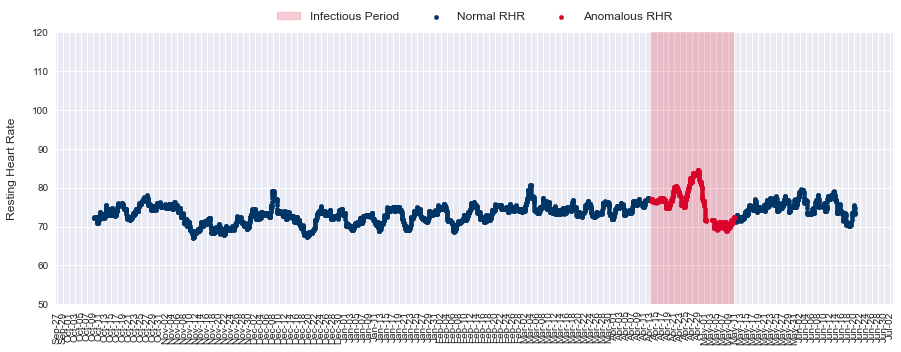

{'Total': 4567, 'TP': 97, 'FP': 0, 'FN': 440, 'TN': 4030, 'Sensitivity': 0.18063314711359404, 'Specificity': 1.0, 'PPV': 1.0, 'NPV': 0.901565995525727, 'Precision': 1.0, 'Recall': 0.18063314711359404, 'Fbeta': 0.9570186578099051, 'F1': 0.305993690851735}
{'Total': 1759, 'TP': 33, 'FP': 0, 'FN': 61, 'TN': 1665, 'Sensitivity': 0.35106382978723405, 'Specificity': 1.0, 'PPV': 1.0, 'NPV': 0.9646581691772885, 'Precision': 1.0, 'Recall': 0.35106382978723405, 'Fbeta': 0.9820271066588097, 'F1': 0.5196850393700788}


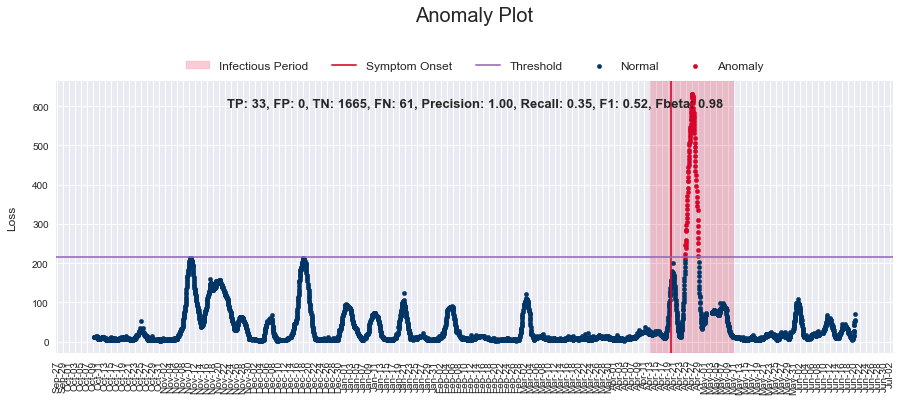

In [67]:
idx = 30
subject_id = subject_info['ID'][idx]
symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

path = join(config['EXP_DIR'], subject_id + "_VAE_all_result.csv")

date_dict = {
    'onset': symptom_onset,
    'before_7': symptom_onset + timedelta(days=-7),
    'before_10': symptom_onset + timedelta(days=-10),
    'before_20': symptom_onset + timedelta(days=-20),
    'after_14': symptom_onset + timedelta(days=14),
    'after_21': symptom_onset + timedelta(days=21),
}

result_df = pd.read_csv(path, index_col='datetime')
result_df.index = pd.to_datetime(result_df.index)

result_df.index = result_df.index + timedelta(hours=config['LEN_WIN'])
result_df

plot.rhr_plot(config, result_df, date_dict, title='')

print(get_metrics(result_df, date_dict))
print(get_metrics_new(result_df, date_dict))

plot.anomaly_plot(config, result_df, date_dict, result_df['MTE'][0],
                  get_metrics_new(result_df, date_dict), title=f"Anomaly Plot", ref=f"VAE",
                  save_plot=False, close_plot=False)


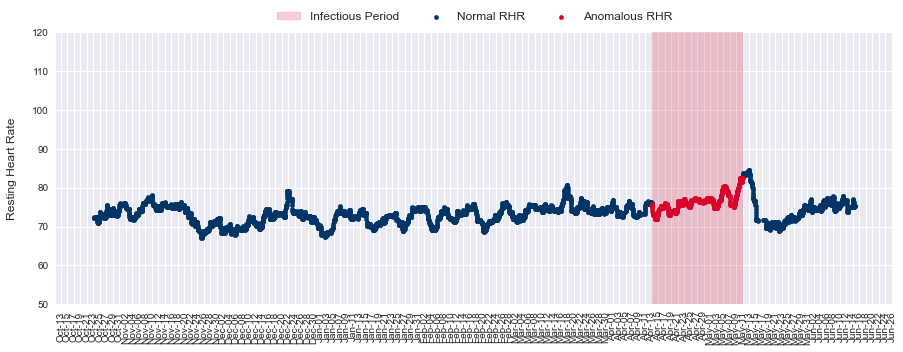

{'Total': 4231, 'TP': 345, 'FP': 4, 'FN': 171, 'TN': 3711, 'Sensitivity': 0.6686046511627907, 'Specificity': 0.9989232839838492, 'PPV': 0.9885386819484241, 'NPV': 0.9559505409582689, 'Precision': 0.9885386819484241, 'Recall': 0.6686046511627907, 'Fbeta': 0.9838773435735261, 'F1': 0.7976878612716763}
{'Total': 1613, 'TP': 92, 'FP': 0, 'FN': 7, 'TN': 1514, 'Sensitivity': 0.9292929292929293, 'Specificity': 1.0, 'PPV': 1.0, 'NPV': 0.9953977646285339, 'Precision': 1.0, 'Recall': 0.9292929292929293, 'Fbeta': 0.9992472308850414, 'F1': 0.9633507853403142}


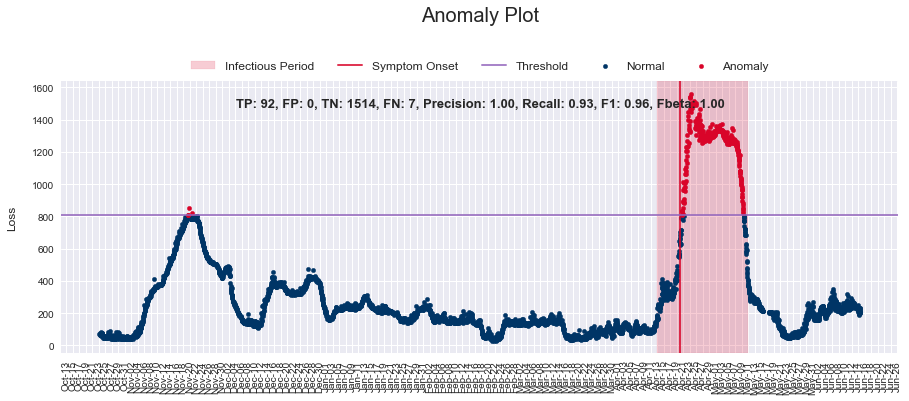

In [68]:
idx = 30
subject_id = subject_info['ID'][idx]
symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

path = join(config['EXP_DIR'], subject_id + "_LSTM_all_result.csv")

date_dict = {
    'onset': symptom_onset,
    'before_7': symptom_onset + timedelta(days=-7),
    'before_10': symptom_onset + timedelta(days=-10),
    'before_20': symptom_onset + timedelta(days=-20),
    'after_14': symptom_onset + timedelta(days=14),
    'after_21': symptom_onset + timedelta(days=21),
}

result_df = pd.read_csv(path, index_col='datetime')
result_df.index = pd.to_datetime(result_df.index)

result_df.index = result_df.index + \
    timedelta(hours=config['LEN_WIN']*config['N_WIN'])

result_df

plot.rhr_plot(config, result_df, date_dict, title='')

print(get_metrics(result_df, date_dict))
print(get_metrics_new(result_df, date_dict))

plot.anomaly_plot(config, result_df, date_dict, result_df['MTE'][0],
                  get_metrics_new(result_df, date_dict), title=f"Anomaly Plot", ref=f"LSTM",
                  save_plot=False, close_plot=False)


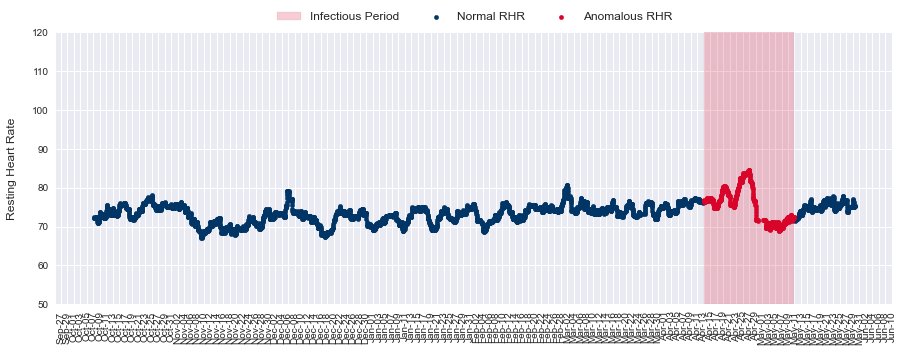

{'Total': 4231, 'TP': 220, 'FP': 129, 'FN': 333, 'TN': 3549, 'Sensitivity': 0.39783001808318263, 'Specificity': 0.9649265905383361, 'PPV': 0.6303724928366762, 'NPV': 0.9142194744976816, 'Precision': 0.6303724928366762, 'Recall': 0.39783001808318263, 'Fbeta': 0.6267452683834935, 'F1': 0.48780487804878053}
{'Total': 1618, 'TP': 30, 'FP': 1, 'FN': 64, 'TN': 1523, 'Sensitivity': 0.3191489361702128, 'Specificity': 0.9993438320209974, 'PPV': 0.967741935483871, 'NPV': 0.9596723377441714, 'Precision': 0.967741935483871, 'Recall': 0.3191489361702128, 'Fbeta': 0.9486537257357545, 'F1': 0.4800000000000001}


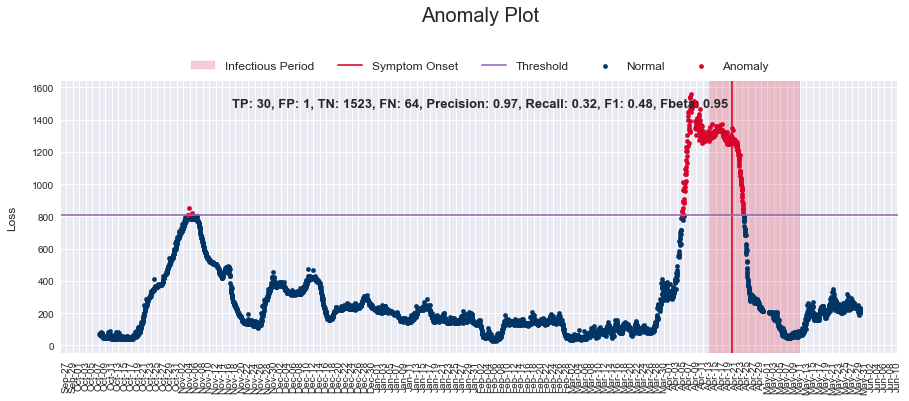

In [69]:
idx = 30
subject_id = subject_info['ID'][idx]
symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

path = join(config['EXP_DIR'], subject_id + "_LSTM_all_result.csv")

date_dict = {
    'onset': symptom_onset,
    'before_7': symptom_onset + timedelta(days=-7),
    'before_10': symptom_onset + timedelta(days=-10),
    'before_20': symptom_onset + timedelta(days=-20),
    'after_14': symptom_onset + timedelta(days=14),
    'after_21': symptom_onset + timedelta(days=21),
}

result_df = pd.read_csv(path, index_col='datetime')
result_df.index = pd.to_datetime(result_df.index)

# result_df.index = result_df.index + \
#     timedelta(hours=config['LEN_WIN']*config['N_WIN'])

result_df

plot.rhr_plot(config, result_df, date_dict, title='')

print(get_metrics(result_df, date_dict))
print(get_metrics_new(result_df, date_dict))

plot.anomaly_plot(config, result_df, date_dict, result_df['MTE'][0],
                  get_metrics_new(result_df, date_dict), title=f"Anomaly Plot", ref=f"LSTM",
                  save_plot=False, close_plot=False)


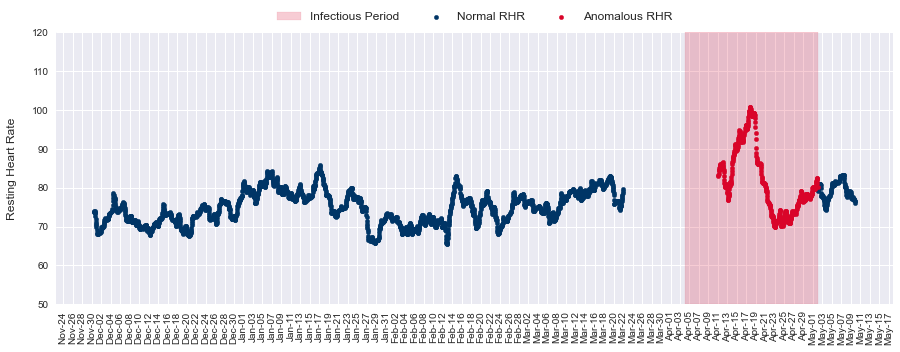

In [32]:
tn_mask = (result_df.index <= date_dict['before_20']) | \
    (result_df.index > date_dict['onset'])

a = result_df[tn_mask]

plot.rhr_plot(config, a, date_dict, title='')


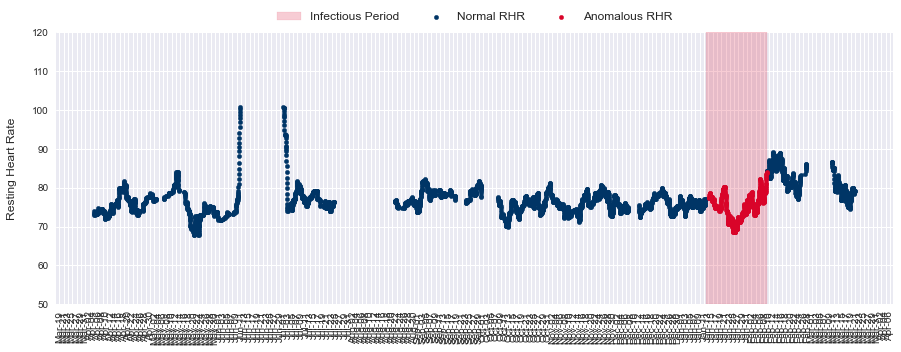

{'Total': 4395, 'TP': 0, 'FP': 2, 'FN': 478, 'TN': 3915, 'Sensitivity': 0.0, 'Specificity': 0.9994894051570079, 'PPV': 0.0, 'NPV': 0.8911905303892557, 'Precision': 0.0, 'Recall': 0.0, 'Fbeta': 0, 'F1': 0}
{'Total': 1400, 'TP': 0, 'FP': 2, 'FN': 74, 'TN': 1324, 'Sensitivity': 0.0, 'Specificity': 0.9984917043740573, 'PPV': 0.0, 'NPV': 0.9470672389127325, 'Precision': 0.0, 'Recall': 0.0, 'Fbeta': 0, 'F1': 0}


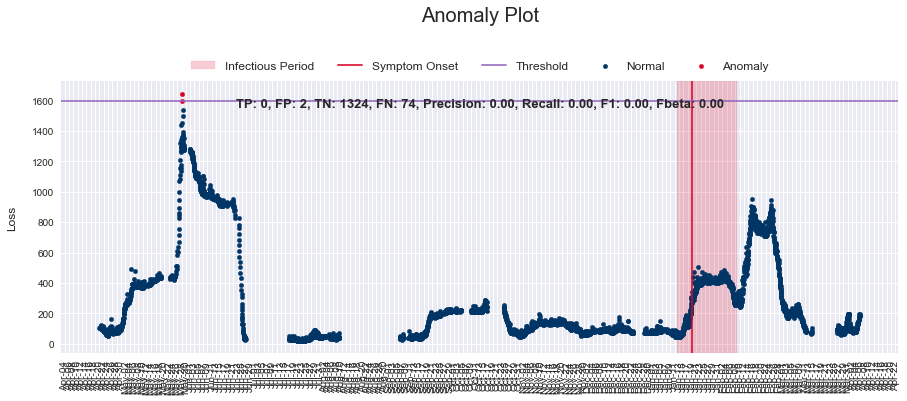

In [86]:
idx = 11
subject_id = subject_info['ID'][idx]
symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

path = join(config['EXP_DIR'], subject_id + "_LSTM_all_result.csv")

date_dict = {
    'onset': symptom_onset,
    'before_7': symptom_onset + timedelta(days=-7),
    'before_10': symptom_onset + timedelta(days=-10),
    'before_20': symptom_onset + timedelta(days=-20),
    'after_14': symptom_onset + timedelta(days=14),
    'after_21': symptom_onset + timedelta(days=21),
}

result_df = pd.read_csv(path, index_col='datetime')
result_df.index = pd.to_datetime(result_df.index)

plot.rhr_plot(config, result_df, date_dict, title='')

result_df.index = result_df.index + \
    timedelta(hours=config['LEN_WIN']*config['N_WIN'])

result_df

print(get_metrics(result_df, date_dict))
print(get_metrics_new(result_df, date_dict))

plot.anomaly_plot(config, result_df, date_dict, result_df['MTE'][0],
                  get_metrics_new(result_df, date_dict), title=f"Anomaly Plot", ref=f"LSTM",
                  save_plot=False, close_plot=False)


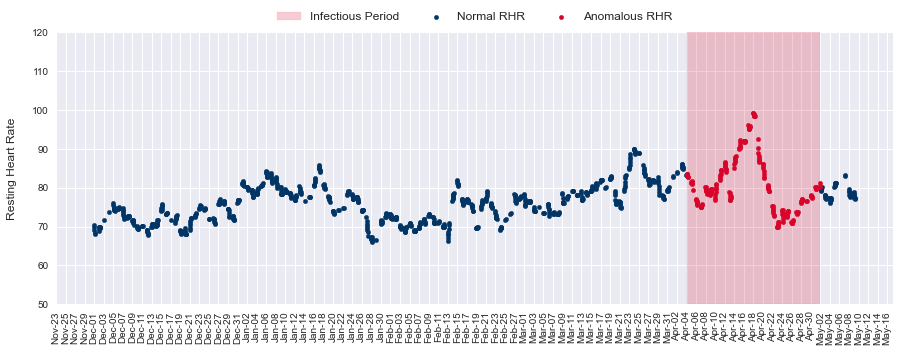

In [48]:
c = result_df.drop(result_df.between_time("7:00", "22:00").index)
plot.rhr_plot(config, c, date_dict, title='')


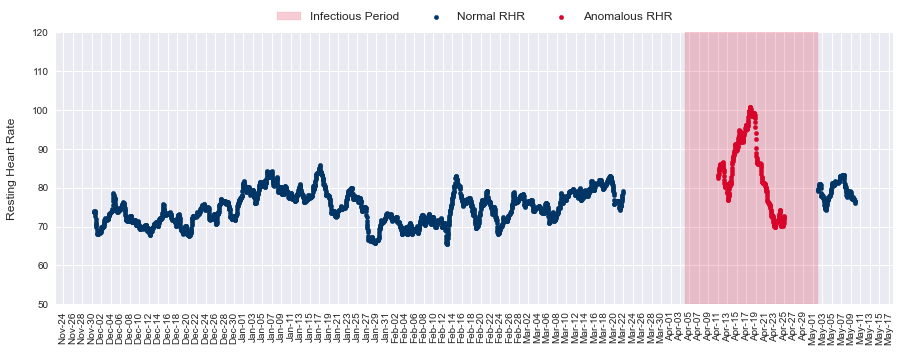

In [38]:
drop_mask = ((result_df.index >= date_dict['before_20']) & \
             (result_df.index < date_dict['onset'])) | \
            ((result_df.index > date_dict['after_14']) &\
             (result_df.index <= date_dict['after_21']))
b = result_df.drop(result_df[drop_mask].index)

plot.rhr_plot(config, b, date_dict, title='')


In [22]:
result_df[drop_mask]


ValueError: Item wrong length 3302 instead of 2876.

In [7]:
get_metrics(result_df, date_dict)

{'Total': 3302,
 'TP': 273,
 'FP': 184,
 'FN': 355,
 'TN': 2490,
 'Sensitivity': 0.43471337579617836,
 'Specificity': 0.931189229618549,
 'PPV': 0.5973741794310722,
 'NPV': 0.875219683655536,
 'Precision': 0.5973741794310722,
 'Recall': 0.43471337579617836,
 'Fbeta': 0.5951692281125885,
 'F1': 0.5032258064516129}

In [27]:
idx = 2
subject_id = subject_info['ID'][idx]
symptom_onset = pd.to_datetime(subject_info['Symptom Onset'][idx])

path = join(config['EXP_DIR'], subject_info['ID'][idx] + "_LSTM_all_result.csv")

date_dict = {
    'onset': symptom_onset,
    'before_7': symptom_onset + timedelta(days=-7),
    'before_10': symptom_onset + timedelta(days=-10),
    'before_20': symptom_onset + timedelta(days=-20),
    'after_21': symptom_onset + timedelta(days=21),
}

result_df = pd.read_csv(path, index_col='datetime')
result_df.index = pd.to_datetime(result_df.index)

get_metrics(result_df, date_dict)


{'Total': 1062,
 'TP': 241,
 'FP': 529,
 'FN': 162,
 'TN': 130,
 'Sensitivity': 0.598014888337469,
 'Specificity': 0.19726858877086495,
 'PPV': 0.312987012987013,
 'NPV': 0.4452054794520548,
 'Precision': 0.312987012987013,
 'Recall': 0.598014888337469,
 'Fbeta': 0.31447101533532296,
 'F1': 0.4109121909633419}

In [28]:
def get_metrics(result_df, date_dict):

    anomalies = result_df[result_df['pred_anomaly'] == True]
    normals = result_df[result_df['pred_anomaly'] == False]

    tp_mask = (anomalies.index > date_dict['before_7']) & \
              (anomalies.index <= date_dict['after_21'])

    fp_mask = (anomalies.index <= date_dict['before_7']) | \
              (anomalies.index > date_dict['after_21'])

    fn_mask = (normals.index > date_dict['before_7']) & \
              (normals.index <= date_dict['after_21'])

    tn_mask = (normals.index <= date_dict['before_7']) | \
              (normals.index > date_dict['after_21'])

    tp = anomalies[tp_mask].shape[0]
    fp = anomalies[fp_mask].shape[0]
    fn = normals[fn_mask].shape[0]
    tn = normals[tn_mask].shape[0]

    Sensitivity = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    Specificity = (tn / (tn+fp)) if (tn+fp) != 0 else 0
    PPV = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    NPV = (tn / (tn+fn)) if (tn+fn) != 0 else 0
    Precision = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    Recall = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    if (Precision != 0 and Recall != 0):
        F1 = 2 * (((tp / (tp+fp)) * (tp / (tp+fn))) /
                  ((tp / (tp+fp)) + (tp / (tp+fn))))
        Fbeta = ((1+0.1**2) * ((tp / (tp+fp)) * (tp / (tp+fn)))) / \
            ((0.1**2) * (tp / (tp+fp)) + (tp / (tp+fn)))
        # F1 = 2 * ((Precision * Recall) / (Precision + Recall))
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    else:
        F1 = 0
        Fbeta = 0

    metrics = {
        'Total': tp+fp+fn+tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'PPV': PPV,
        'NPV': NPV,
        'Precision': Precision,
        'Recall': Recall,
        'Fbeta': Fbeta,
        'F1': F1
    }

    return metrics

In [8]:
def compile_metrics(subject_info, exp_dir, ref):
    # Compile metrics
    df = pd.DataFrame()
    for idx in range(len(subject_info['ID'])):
        metrics_dir = join(
            exp_dir, subject_info["ID"][idx] + f"_{ref}_metrics.csv")
        if not os.path.isfile(metrics_dir):
            continue
        temp = pd.read_csv(metrics_dir)
        print(temp.shape)
        df = pd.concat([df, temp], ignore_index=True)
    print(df, df.shape)
    # Process metrics
    tp = df['TP'].sum()
    fp = df['FP'].sum()
    fn = df['FN'].sum()
    tn = df['TN'].sum()

    Sensitivity = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    Specificity = (tn / (tn+fp)) if (tn+fp) != 0 else 0
    PPV = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    NPV = (tn / (tn+fn)) if (tn+fn) != 0 else 0
    Precision = (tp / (tp+fp)) if (tp+fp) != 0 else 0
    Recall = (tp / (tp+fn)) if (tp+fn) != 0 else 0
    if (Precision != 0 and Recall != 0):
        # F1 = 2 * ((Precision * Recall) / (Precision + Recall))
        F1 = 2 * (((tp / (tp+fp)) * (tp / (tp+fn))) /
                  ((tp / (tp+fp)) + (tp / (tp+fn))))
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
        Fbeta = ((1+0.1**2) * ((tp / (tp+fp)) * (tp / (tp+fn)))) / \
            ((0.1**2) * (tp / (tp+fp)) + (tp / (tp+fn)))
    else:
        F1 = 0
        Fbeta = 0

    compiled_dict = {
        'ID': f"{ref}_Summary",
        'Threshold': df['threshold'][0],
    }

    compiled_dict.update(df['Detection'].value_counts().to_dict())

    detection = f"{df['Detection'].value_counts()['Early']/len(df)*100:0.2f}% : " +\
                f"{df['Detection'].value_counts()['Late']/len(df)*100:0.2f}% : " +\
                f"{df['Detection'].value_counts()['Failed']/len(df)*100:0.2f}%"

    metrics = {
        'Detection': detection,
        'Total': tp+fp+fn+tn,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'PPV': PPV,
        'NPV': NPV,
        'Precision': Precision,
        'Recall': Recall,
        'Fbeta': Fbeta,
        'F1': F1
    }

    compiled_dict.update(metrics)

    return pd.DataFrame(compiled_dict, index=[0])

In [3]:
for model in ['VAE', 'LSTM']:
    compiled = compile_metrics(subject_info, config['EXP_DIR'], model)
    display(compiled)
    compiled.to_csv(join(config['EXP_DIR'], f"compiled_{model}_metrics.csv"), 
                    index=False)

,ID,Threshold,Late,Early,Failed,Detection,Total,TP,FP,FN,TN,Sensitivity,Specificity,PPV,NPV,Precision,Recall,Fbeta,F1
0,VAE_Summary,MTE,7,6,4,35.29% : 41.18% : 23.53%,29474,2486,1363,5818,19807,0.299374,0.935616,0.645882,0.772956,0.645882,0.299374,0.638564,0.409117


,ID,Threshold,Early,Failed,Late,Detection,Total,TP,FP,FN,TN,Sensitivity,Specificity,PPV,NPV,Precision,Recall,Fbeta,F1
0,LSTM_Summary,MTE,11,4,2,64.71% : 11.76% : 23.53%,23762,3806,6921,1503,11532,0.716896,0.624939,0.354806,0.884695,0.354806,0.716896,0.356589,0.474682


# Import & Process Data

In [7]:
# Choose which data index from subject_info to run the experiment on
idx = 0

# Prepare data
data = Data(config=config, data_info=subject_info, index=idx)

# Log data properties
if data.error == True:
    print(data.error_message)
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(
            f"Index {idx}\t {data.id} {'-'*4} Data properties... ✘ ... {data.error_message}\n")
    # Use continue if run in a loop; otherwise raise error
    # continue
    raise ValueError("Data does not meet experiment criteria!")
else:
    print("Data properties... ✔\n")
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(f"Index {idx}\t {data.id} {'-'*4} Data properties... ✔\n")

# Print data info
data.print_info()

# Export dates
pd.DataFrame(data.date_dict, index=[0]).to_csv(
    join(config['EXP_DIR'], data.id + "_dates.csv"), index=False)


Data properties... ✔

            Subject Info
            Index:                0
            Phase:                phase2
            Group:                covid
            ID:                   P111019
            Device:               Fitbit
            
            Dataset Shape
            VAE Train:            (2199, 48, 1)
            VAE Train-aug:        (17592, 48, 1)
            VAE Test:             (1392, 48, 1)
            VAE Merged:           (3638, 48, 1)
            LSTM Train:           (1863, 8, 48, 1)
            LSTM Test:            (1056, 8, 48, 1)
            LSTM Merged:          (3302, 8, 48, 1)
        


In [20]:
def rhr_plot(config, data_df, date_dict, title, ref="",
             save_plot=False, close_plot=False):

    plt.style.use('seaborn')
    plt.rcParams['font.family'] = "Arial"  # "Bahnschrift"
    plt.rcParams['figure.figsize'] = 15, 5

    data_df.index.name = 'datetime'
    data_df = data_df.reset_index()

    fig, ax = plt.subplots()

    # plot infectious period
    ax.axvspan(date_dict['before_7'], date_dict['after_21'],
               color='#d90429',
               label='Infectious Period',
               alpha=0.2)

    normal_mask = (data_df['datetime'] <= date_dict['before_7']) | \
                  (data_df['datetime'] > date_dict['after_21'])

    anomaly_mask = (data_df['datetime'] > date_dict['before_7']) & \
                   (data_df['datetime'] <= date_dict['after_21'])

    # plot anomaly scores
    normal = data_df.loc[normal_mask]
    anomaly = data_df.loc[anomaly_mask]

    ax.scatter(normal['datetime'], normal['RHR'], s=20,
               c='#003566',
               label='Normal RHR')
    ax.scatter(anomaly['datetime'], anomaly['RHR'], s=20,
               c='#d90429',
               label='Anomalous RHR')
    ax.axvline(date_dict['onset'],
               color='#d90429',
               label='Symptom Onset',
               linestyle='solid',
               lw=2,
               alpha=0.8)

    # ax.scatter(data_df['datetime'], data_df['RHR'], s=20,
    #            c='#003566',
    #            label='Resting Heart Rate')

    # Format x ticks
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    plt.xticks(rotation=90)

    # Plot info
    plt.title(title, fontsize=20, pad=38)
    plt.ylabel('Resting Heart Rate', fontsize=12, labelpad=15)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), fontsize=12,
               loc="lower center", borderaxespad=0, ncol=5)
    # Set y-limit
    rhr_max = data_df['RHR'].max()
    rhr_min = data_df['RHR'].min()
    plt.ylim((rhr_min if rhr_min < 50 else 50,
              rhr_max if (rhr_max > 120) else 120))

    plt.show()

# VAE Model

#### Assign and Compile VAE Model

In [8]:
# Get VAE model
vae_model = cnn_vae.VAE(n_timesteps=config['LEN_WIN'],
                        n_channels=data.train_dataset_vae.shape[-1],
                        latent_dim=config['LATENT_DIM'])
vae_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(
                      learning_rate=config['LEARNING_RATE']),
                  metrics=[tf.metrics.MeanSquaredError()])

# Show VAE model summary
print("\nVAE Model Summary")
print("=================", end="\n\n")
vae_model.print_summary()



VAE Model Summary

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 48, 1)]      0           []                               
                                                                                                  
 encoder1 (Conv1D)              (None, 24, 128)      512         ['encoder_input[0][0]']          
                                                                                                  
 encoder2 (Conv1D)              (None, 12, 64)       24640       ['encoder1[0][0]']               
                                                                                                  
 encoder3 (Conv1D)              (None, 6, 32)        6176        ['encoder2[0][0]']               
                                                                        

#### Train VAE Model

In [9]:
# Assign checkpoint paths
vae_ckpt_path = join(
    config['EXP_DIR'], data.id + "_vae_checkpoint", "ckpt")

# Callbacks for VAE
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(vae_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

if not os.path.isfile(vae_ckpt_path + ".index"):
    # Train VAE
    vae_history = vae_model.fit(data.train_aug_dataset_vae,
                                validation_split=config['VAL_SPLIT'],
                                batch_size=config['BATCH_SIZE'],
                                epochs=config['EPOCH'],
                                shuffle=False,
                                verbose=1,
                                callbacks=[early_stopping_callback, checkpoint_callback])

    # Export model history
    export_history(vae_history, join(
        config['EXP_DIR'], data.id + "_vae_history.csv"))

    # Plot loss curve
    # print("\nVAE Loss Curve")
    # print("==============", end="\n")
    plot.loss_curve(config, vae_history, ref=data.id + "_VAE", save_plot=True,
                    close_plot=True)

else:
    vae_model.load_weights(vae_ckpt_path)
    print("VAE model weights loaded from:")
    print(vae_ckpt_path)


VAE model weights loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_vae_checkpoint\ckpt


# Generate Embeddings

In [10]:
if not os.path.isfile(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib")):
    # Get embedding dataset
    embed_gen = EmbedGen(config, vae_model,
                         data, verbose=True)

    # Save embed_gen object
    dump(embed_gen, join(config['EXP_DIR'],
                         f"{data.id}_embeddings.joblib"))
else:
    # Load embed_gen object
    embed_gen = load(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))
    print("Embeddings loaded from:")
    print(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))


Embeddings loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_embeddings.joblib


# LSTM Model for Embeddings

#### Assign and Compile LSTM Model

In [11]:
# Get LSTM MODEL
lstm_model = lstm_autoencoder(n_timesteps=config['N_WIN'] - 1,
                              n_features=config['LATENT_DIM'])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                   optimizer=tf.optimizers.Adam(
                       learning_rate=config['LEARNING_RATE']),
                   metrics=['mse'])

# Show LSTM model summary
print("\nLSTM Model Summary")
print("==================", end="\n\n")
lstm_model.summary()



LSTM Model Summary

Model: "LSTM_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 encoder1 (LSTM)             (None, 7, 128)            69120     
                                                                 
 encoder2 (LSTM)             (None, 64)                49408     
                                                                 
 repeat_vec (RepeatVector)   (None, 7, 64)             0         
                                                                 
 decoder1 (LSTM)             (None, 7, 64)             33024     
                                                                 
 decoder2 (LSTM)             (None, 7, 128)            98816     
                                                                 
 reconst (TimeDistributed)   

#### Train LSTM Model

In [12]:
# Assign checkpoint paths
lstm_ckpt_path = join(
    config['EXP_DIR'], data.id + "_lstm_checkpoint", "ckpt")
    
# Callbacks for LSTM
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(lstm_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

if not os.path.isfile(lstm_ckpt_path + ".index"):
    # Train LSTM
    lstm_history = lstm_model.fit(embed_gen.x_train, embed_gen.y_train,
                                  validation_data=(
                                      embed_gen.x_test, embed_gen.y_test),
                                  batch_size=config['BATCH_SIZE'],
                                  epochs=config['EPOCH'],
                                  callbacks=[
                                      early_stopping_callback, checkpoint_callback],
                                  verbose=1)

    # Export model history
    export_history(lstm_history, join(
        config['EXP_DIR'], data.id + "_lstm_history.csv"))

    # Plot loss curve
    # print("\nLSTM Loss Curve")
    # print("===============", end="\n")
    plot.loss_curve(config, lstm_history, ref=data.id + "_LSTM", save_plot=True,
                    close_plot=True)
else:
    lstm_model.load_weights(lstm_ckpt_path)
    print("LSTM model weights loaded from:")
    print(lstm_ckpt_path)


LSTM model weights loaded from:
e:\Repositories\PCovNet\src\..\experiment\phase2_covid_user_all_(48-8)_1000\P111019_lstm_checkpoint\ckpt


# Evaluate VAE Model

#### Calculate Loss for VAE Model

In [13]:
# Calculate vae losses
print("\n")
print("Calculate vae train loss... ", end="")
train_loss = vae_model.get_loss_array(data.train_dataset_vae)
print("✓")
print("Calculate vae test loss... ", end="")
test_loss = vae_model.get_loss_array(data.test_dataset_vae)
print("✓")
print("Calculate vae all loss... ", end="")
seq_loss = vae_model.get_loss_array(data.merged_dataset_vae)
print("✓")
print("\n")




Calculate vae train loss... ✓
Calculate vae test loss... ✓
Calculate vae all loss... ✓




#### Evaluate Results for VAE Model

Loss Distribution Plot


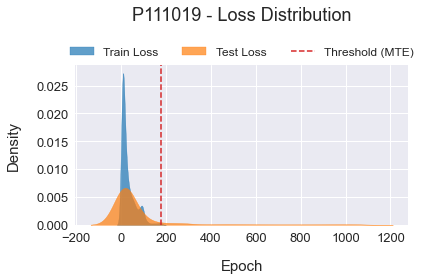


Metrics


{'threshold': 'MTE',
 'Detection': 'Late',
 'Total': 3638,
 'TP': 128,
 'FP': 49,
 'FN': 500,
 'TN': 2961,
 'Sensitivity': 0.20382165605095542,
 'Specificity': 0.9837209302325581,
 'PPV': 0.7231638418079096,
 'NPV': 0.8555330829240104,
 'Precision': 0.7231638418079096,
 'Recall': 0.20382165605095542,
 'Fbeta': 0.7053688345700566,
 'F1': 0.31801242236024846}


RHR Plot


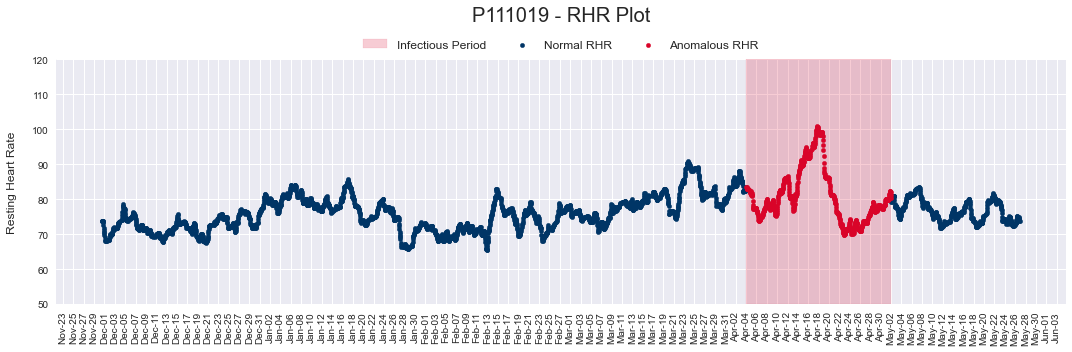


Anomaly Plot


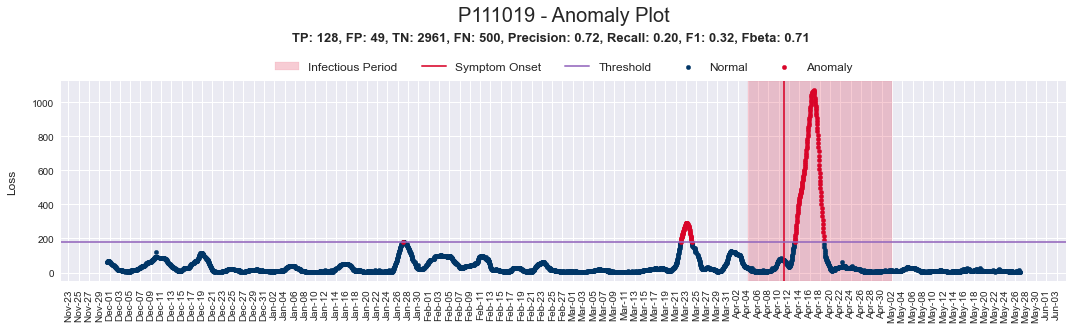

In [ ]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(config, train_loss, test_loss, threshold_dict, ref=f"{data.id}_VAE",
               save_plot=True, close_plot=True)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_VAE")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_VAE", save_plot=True, close_plot=True)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(config, loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_VAE",
                  save_plot=True, close_plot=True)


# Evaluate LSTM Model

#### Calculate Loss for LSTM Model

In [ ]:
# Calculate vae-lstm losses
print("\n")
print("Calculate lstm train loss... ", end="")
train_loss = get_vae_lstm_loss(data.train_dataset_lstm,
                               vae_model, lstm_model)
print("Calculate lstm test loss... ", end="")
test_loss = get_vae_lstm_loss(data.test_dataset_lstm,
                              vae_model, lstm_model)
print("Calculate lstm all loss... ", end="")
seq_loss = get_vae_lstm_loss(data.merged_dataset_lstm,
                             vae_model, lstm_model)
print("\n")


#### Evaluate Results for VAE Model

Loss Distribution Plot


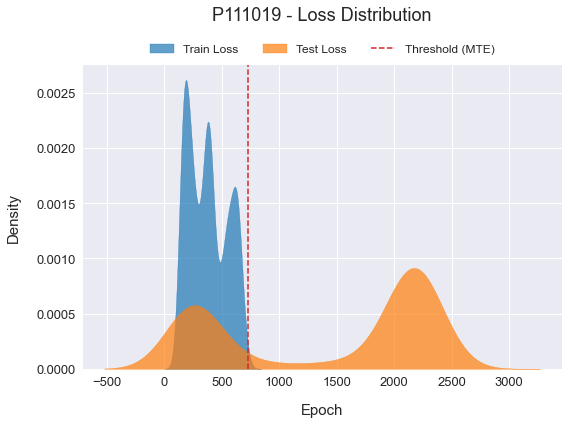


Metrics


{'threshold': 'MTE',
 'Detection': 'Late',
 'Total': 3110,
 'TP': 280,
 'FP': 402,
 'FN': 316,
 'TN': 2112,
 'Sensitivity': 0.4697986577181208,
 'Specificity': 0.8400954653937948,
 'PPV': 0.41055718475073316,
 'NPV': 0.8698517298187809,
 'Precision': 0.41055718475073316,
 'Recall': 0.4697986577181208,
 'Fbeta': 0.4110704110704111,
 'F1': 0.4381846635367762}


RHR Plot


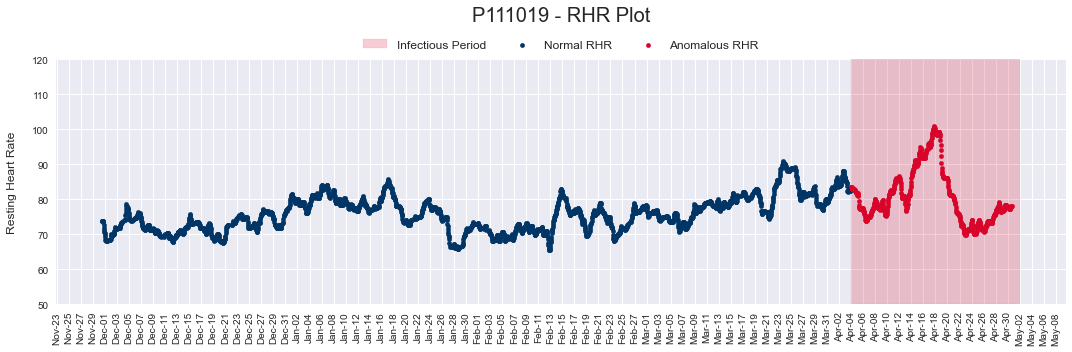


Anomaly Plot


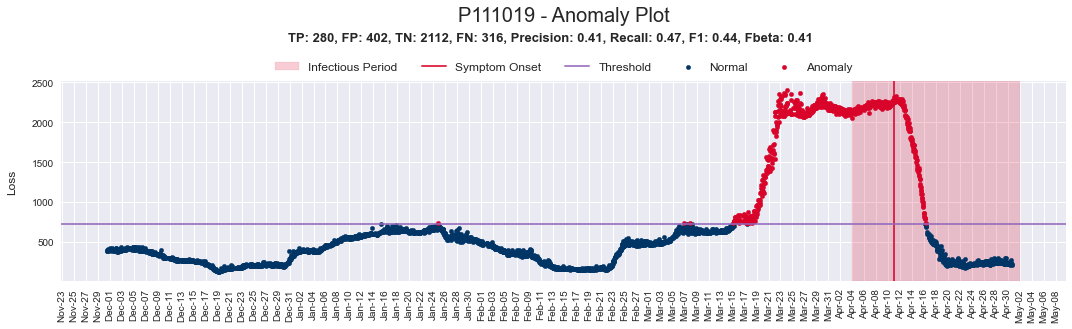

In [ ]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(config, train_loss, test_loss, threshold_dict, ref=f"{data.id}_LSTM",
               save_plot=True, close_plot=True)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_LSTM")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(config, loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_LSTM", save_plot=True, close_plot=True)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(config, loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_LSTM",
                  save_plot=True, close_plot=True)
